# Anime Dataset Project

In [1]:
pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 3.4MB/s 


In [2]:
# import dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/Skantastico/DS-Unit-2-Applied-Modeling/master/data/Anime_No_NaNs.csv'

df = pd.read_csv(url)

df.sample(10)

,name,type,source,producers,genre,studio,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites
1764,Carol,OVA,Novel,['Magic Bus'],"['Fantasy', 'Magic', 'Shoujo']",[],1.0,False,1 hr,PG-13 - Teens 13 or older,5.24,250.0,9400.0,9330.0,771.0,0.0
7383,Toki no Daichi: Hana no Oukoku no Majo,OVA,Manga,['Magic Bus'],"['Adventure', 'Fantasy']",[],3.0,False,30 min per ep,PG-13 - Teens 13 or older,5.50,30.0,13279.0,12223.0,197.0,0.0
10006,Kobutori (1957),Movie,Other,[],[],[],1.0,False,20 min,G - All Ages,5.30,53.0,9325.0,12755.0,164.0,0.0
6282,Hidamari Sketch x SP,Special,4-koma manga,"['Aniplex', 'Lantis', 'TBS', 'Movic', 'Houbuns...","['Slice of Life', 'Comedy', 'School', 'Seinen']",['Shaft'],2.0,False,24 min per ep,PG-13 - Teens 13 or older,7.84,4977.0,819.0,3957.0,10123.0,8.0
9776,Pinky Monkey x FaFa Collaboration Animation: A...,ONA,Other,[],['Slice of Life'],[],1.0,False,1 min,G - All Ages,4.99,60.0,9769.0,13065.0,149.0,0.0
9942,The iDOLM@STER Million Live! 1st Anniversary PV,Special,Game,[],['Drama'],['A-1 Pictures'],1.0,False,42 sec,PG-13 - Teens 13 or older,6.01,594.0,7709.0,7157.0,2195.0,0.0
6913,Kaguya-hime: Taketori Monogatari,OVA,Unknown,[],"['Hentai', 'Historical']",[],1.0,False,27 min,Rx - Hentai,4.68,159.0,NaN,9858.0,586.0,1.0
11333,Ganbare!! Tabuchi-kun!!,Movie,4-koma manga,['Tokyo Movie Shinsha'],"['Comedy', 'Sports']",[],1.0,False,1 hr 35 min,PG-13 - Teens 13 or older,5.67,27.0,10973.0,13114.0,146.0,0.0
7569,Kero Kero Keroppi no Christmas Eve no Okurimono,OVA,Unknown,['Sanrio'],"['Fantasy', 'Kids']",[],1.0,False,25 min,G - All Ages,6.08,64.0,7474.0,11923.0,219.0,0.0
6279,Machikado no Märchen,OVA,Original,['Kitty Films'],"['Music', 'Romance']",[],1.0,False,54 min,PG-13 - Teens 13 or older,6.39,114.0,6244.0,9407.0,748.0,3.0


In [3]:
# Doing some final cleaning, currently ~15000 samples, and 16 columns
# But there is still significant leakage

df.shape

(14926, 16)

In [4]:
df = df.drop(columns=['rank'])
df

,name,type,source,producers,genre,studio,episodes,airing,duration,rating,score,scored_by,popularity,members,favorites
0,Cowboy Bebop,TV,Original,['Bandai Visual'],"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",['Sunrise'],26.0,False,24 min per ep,R - 17+ (violence & profanity),8.81,405664.0,39.0,795733.0,43460.0
1,Cowboy Bebop: Tengoku no Tobira,Movie,Original,"['Sunrise', 'Bandai Visual']","['Action', 'Drama', 'Mystery', 'Sci-Fi', 'Space']",['Bones'],1.0,False,1 hr 55 min,R - 17+ (violence & profanity),8.41,120243.0,449.0,197791.0,776.0
2,Trigun,TV,Manga,['Victor Entertainment'],"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...",['Madhouse'],26.0,False,24 min per ep,PG-13 - Teens 13 or older,8.30,212537.0,146.0,408548.0,10432.0
3,Witch Hunter Robin,TV,Original,['Bandai Visual'],"['Action', 'Magic', 'Police', 'Supernatural', ...",['Sunrise'],26.0,False,25 min per ep,PG-13 - Teens 13 or older,7.33,32837.0,1171.0,79397.0,537.0
4,Bouken Ou Beet,TV,Manga,"['TV Tokyo', 'Dentsu']","['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",['Toei Animation'],52.0,False,23 min per ep,PG - Children,7.03,4894.0,3704.0,11708.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14921,Te Ke Dong Ji Pian,ONA,Unknown,[],['Action'],[],54.0,False,Unknown,None,NaN,0.0,15461.0,7.0,0.0
14922,Wang Zhe Wai Chuan,ONA,Unknown,[],['Comedy'],[],12.0,False,Unknown,None,NaN,0.0,15472.0,7.0,0.0
14923,Wan Jie Shen Zhu,ONA,Unknown,[],['Fantasy'],[],60.0,False,Unknown,None,NaN,0.0,15470.0,7.0,0.0
14924,Xia Gu Zhong An Zu,ONA,Unknown,[],['Fantasy'],[],12.0,False,Unknown,None,NaN,0.0,15473.0,7.0,0.0


In [5]:
# Still have some NaNs in Score, dropping them

df.isna().sum()

name            0
type            0
source          0
producers       0
genre           0
studio          0
episodes      340
airing          0
duration        0
rating          0
score         148
scored_by       0
popularity      0
members         0
favorites       0
dtype: int64

In [6]:
df = df.dropna(subset=['score'])
df.isna().sum()

name            0
type            0
source          0
producers       0
genre           0
studio          0
episodes      338
airing          0
duration        0
rating          0
score           0
scored_by       0
popularity      0
members         0
favorites       0
dtype: int64

In [7]:
df = df.dropna(subset=['episodes'])
df.isna().sum()

name          0
type          0
source        0
producers     0
genre         0
studio        0
episodes      0
airing        0
duration      0
rating        0
score         0
scored_by     0
popularity    0
members       0
favorites     0
dtype: int64

In [8]:
df

,name,type,source,producers,genre,studio,episodes,airing,duration,rating,score,scored_by,popularity,members,favorites
0,Cowboy Bebop,TV,Original,['Bandai Visual'],"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",['Sunrise'],26.0,False,24 min per ep,R - 17+ (violence & profanity),8.81,405664.0,39.0,795733.0,43460.0
1,Cowboy Bebop: Tengoku no Tobira,Movie,Original,"['Sunrise', 'Bandai Visual']","['Action', 'Drama', 'Mystery', 'Sci-Fi', 'Space']",['Bones'],1.0,False,1 hr 55 min,R - 17+ (violence & profanity),8.41,120243.0,449.0,197791.0,776.0
2,Trigun,TV,Manga,['Victor Entertainment'],"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...",['Madhouse'],26.0,False,24 min per ep,PG-13 - Teens 13 or older,8.30,212537.0,146.0,408548.0,10432.0
3,Witch Hunter Robin,TV,Original,['Bandai Visual'],"['Action', 'Magic', 'Police', 'Supernatural', ...",['Sunrise'],26.0,False,25 min per ep,PG-13 - Teens 13 or older,7.33,32837.0,1171.0,79397.0,537.0
4,Bouken Ou Beet,TV,Manga,"['TV Tokyo', 'Dentsu']","['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",['Toei Animation'],52.0,False,23 min per ep,PG - Children,7.03,4894.0,3704.0,11708.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,Danbou to Reibou,Music,Original,[],"['Dementia', 'Music']",[],1.0,False,2 min,G - All Ages,2.57,21.0,15213.0,38.0,0.0
14849,Hana no Nioi,Music,Original,"[""Toy's Factory""]","['Drama', 'Military', 'Music']",[],1.0,False,5 min,PG - Children,4.35,17.0,15293.0,29.0,0.0
14851,Tomo: Tabidachi no Toki,Music,Original,[],"['Music', 'Kids']",[],1.0,False,2 min,G - All Ages,4.57,7.0,15346.0,19.0,0.0
14885,Hua Jiang Hu Zhi Bu Liang Ren 3rd Season,ONA,Original,[],"['Drama', 'Fantasy', 'Historical', 'Martial Ar...",[],40.0,True,20 min per ep,R - 17+ (violence & profanity),5.50,2.0,15227.0,36.0,0.0


# Data Exploration (with Leakage)

## Create Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Create Train/Test

train, test = train_test_split(df, train_size=0.80, test_size=0.20)

train.shape, test.shape

((11552, 15), (2888, 15))

## Create Train/Val Split

In [10]:
# Create train / val split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((9241, 15), (2311, 15))

## Get Baseline Accuracy, using Linear Regression

In [11]:
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Arrange Data

target = 'score'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Validation Accuracy 0.5110959592437363



## Random Forest

In [12]:
# Random Forest

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6711910773819062


## Try XGBoost/Get Feature Importance

In [13]:
## Try XGBoost

from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

[06:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Accuracy: 0.6577922260060793


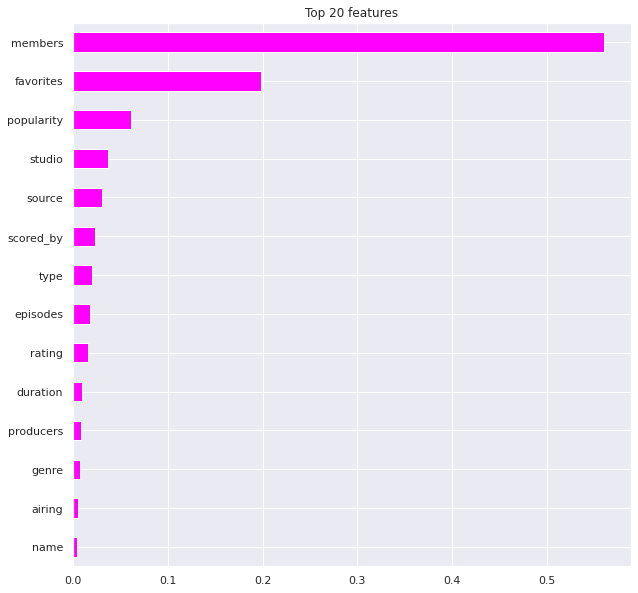

In [14]:
# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='magenta');

### Looks like I have some significant leakage here.

## Get Permutation Importance

In [15]:
!pip install eli5

     |████████████████████████████████| 112kB 4.9MB/s 


In [16]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [17]:
# import eli5

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [18]:
permuter.feature_importances_

array([-2.12011625e-05,  5.17985478e-02,  1.53315970e-02,  6.50248351e-03,
        6.25415508e-03,  3.22452920e-02,  3.96060919e-02,  2.78061070e-04,
        9.28961589e-03,  1.27612565e-02,  1.90321341e-01,  2.09055813e-01,
        2.35779307e-01,  2.60472288e-01])

In [19]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.2605 ± 0.0150,favorites
0.2358 ± 0.0275,members
0.2091 ± 0.0154,popularity
0.1903 ± 0.0246,scored_by
0.0518 ± 0.0072,type
0.0396 ± 0.0076,episodes
0.0322 ± 0.0051,studio
0.0153 ± 0.0039,source
0.0128 ± 0.0039,rating
0.0093 ± 0.0014,duration


This seems to coroborate the leakage issue, the top 4 are huge outliers.

# Data Exploration (Less Leakage)

In [20]:
# Lets drop these columns

less_leak = df.drop(columns=['favorites', 'popularity', 'members', 'scored_by'])

less_leak.shape

(14440, 11)

## Create Train/Test Split

In [21]:
from sklearn.model_selection import train_test_split

# Create Train/Test

train, test = train_test_split(less_leak, train_size=0.80, test_size=0.20)

train.shape, test.shape

((11552, 11), (2888, 11))

## Create Train/Val Split

In [22]:
# Create train / val split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((9241, 11), (2311, 11))

## Get Baseline Accuracy, using Linear Regression

In [23]:
# Arrange Data

import category_encoders as ce

target = 'score'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.10919623345678109


Wow what a huge drop! Confused as to whats causing it. But its just a baseline.

## Random Forest

In [24]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.31372459231094973


## Try XGBoost/Get Feature Importance

In [25]:
## Try XGBoost

from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

[06:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Accuracy: 0.41819066870604465


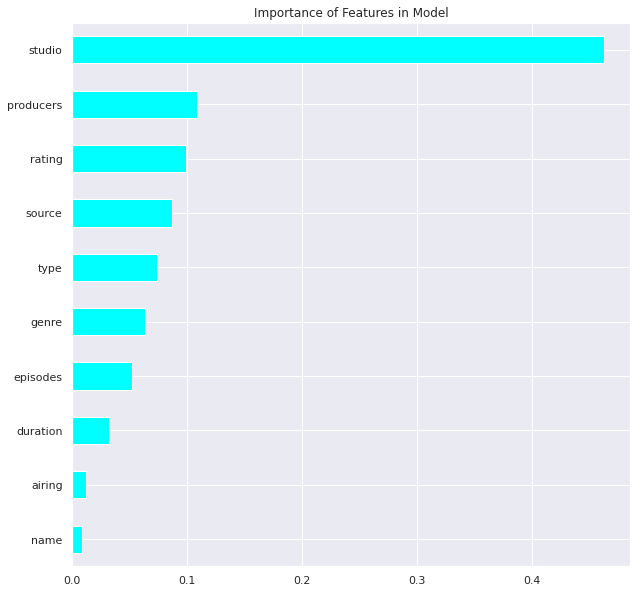

In [26]:
# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Importance of Features in Model')
importances.sort_values()[-n:].plot.barh(color='cyan');

Wow Studio seems to matter a lot. There are definitely top studios that have pedigrees more than in other media types (movies, books, etc)

## Get Permutation Importance

In [27]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [28]:
permuter = PermutationImportance(
    model,
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [29]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.2532 ± 0.0309,studio
0.1054 ± 0.0178,source
0.0553 ± 0.0140,type
0.0441 ± 0.0091,rating
0.0414 ± 0.0152,genre
0.0379 ± 0.0027,episodes
0.0348 ± 0.0103,duration
0.0324 ± 0.0130,producers
-0.0000 ± 0.0003,name
-0.0001 ± 0.0002,airing


# Test Score and Visualizations

In [30]:
# Baseline Accuracy on Val and Test

import category_encoders as ce

target = 'score'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val))
print('Test Accuracy', model.score(X_test_scaled, y_test))

Validation Accuracy 0.10919623345678109
Test Accuracy 0.11117416759898169


In [31]:
# Test Set Accuracy using Random Forest

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Fit on train, score on test
y_pred = pipeline.predict(X_test)
print(f'Test Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.31372459231094985
Test Accuracy 0.3195420760706766


In [32]:
# Test Set Accuracy Using XGBoost

from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))
print('Test Accuracy:', pipeline.score(X_test, y_test))

[06:16:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Accuracy: 0.41819066870604465
Test Accuracy: 0.45353130995382146


In [33]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 68kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=aa06df0c67a92840b367df66c2ae0661dc7603194635262e3665d75d51879899
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6e20d07b38>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6e20d48f28>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


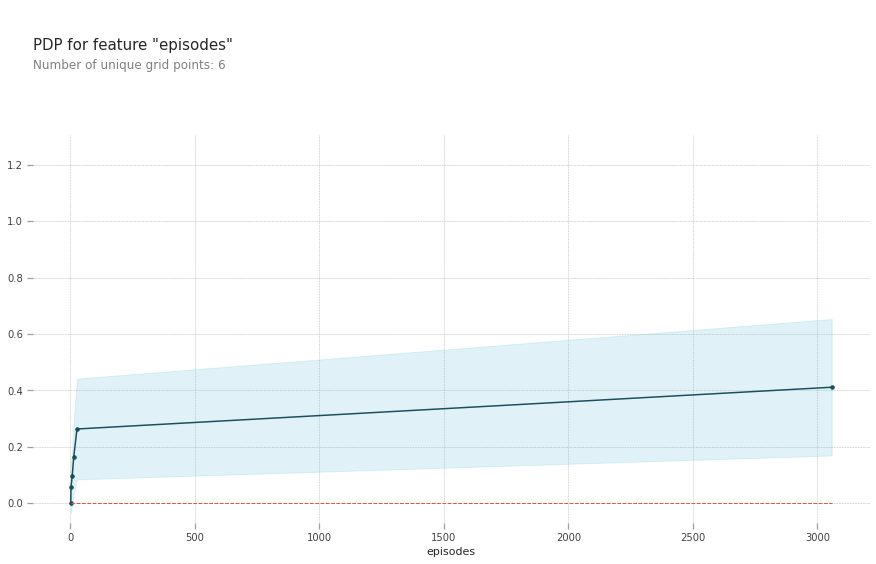

In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'episodes'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
sns.set()
pdp_plot(isolated, feature_name=feature)

### Visualization of Accuracy of Different Models

In [35]:
from IPython.display import Image

Image(url="https://raw.githubusercontent.com/Skantastico/DS-Unit-2-Applied-Modeling/master/data/Visualizations/Permutation%20Importance%20Comparison.png")

In [36]:
Image(url="https://raw.githubusercontent.com/Skantastico/DS-Unit-2-Applied-Modeling/master/data/Visualizations/Sidebyside%20Feature%20Importance.png")

In [37]:
from IPython.display import Image

Image(url="https://github.com/Skantastico/DS-Unit-2-Applied-Modeling/raw/master/data/Visualizations/Model%20Vs%20Accuracy%20Plot.PNG")

In [38]:
Image(url="https://raw.githubusercontent.com/Skantastico/DS-Unit-2-Applied-Modeling/master/data/Visualizations/Baseline%20Model%20Accuracy%20vs%20RF%20and%20XGB.png")

# Trying Shap Plots and Testing Model


In [39]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train_scaled, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.5s finished


In [40]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.596850157946487, 'n_estimators': 171}
Cross-validation MAE 0.6009117445608976


In [41]:
y_train.mean()

6.2868401688128985

In [42]:
# Get Individual Observation

row = X_test.iloc[[110]]
row

,name,type,source,producers,genre,studio,episodes,airing,duration,rating
11820,Tian Xin Ge Ge 2nd Season,TV,Original,[],"['Comedy', 'Historical', 'Kids']",['Puzzle Animation Studio Limited'],52.0,False,22 min per ep,None


In [43]:
# What was the MyAnimeList rating of this?

y_test.iloc[[110]]

11820    7.29
Name: score, dtype: float64

In [44]:
# What did my model predict?

pipeline.predict(row)

array([6.2493625], dtype=float32)

In [45]:
!pip install shap

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489406 sha256=fceaa43955aa5fe5fef0dc65ae6ed2758f69a662f055e4b6860c644922a8b09f
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [46]:
# Test Set Accuracy Using XGBoost

from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))
print('Test Accuracy:', pipeline.score(X_test, y_test))

[06:17:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Accuracy: 0.41819066870604465
Test Accuracy: 0.45353130995382146


In [47]:
# Why did my model predict this?

import shap

enc = pipeline.named_steps['ordinalencoder']
enc_row = enc.transform(row)

xgb = pipeline.named_steps['xgbregressor']

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(enc_row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [48]:
row = X_test.iloc[[1750]]

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [49]:
row = X_test.iloc[[150]]

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)